In [7]:
from glob import glob as gg
#
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import rc as rc
#
from netCDF4 import Dataset  
#
from datetime import datetime
from datetime import date
#
import pandas as pd
#
import gsw

In [9]:
class mesh_data:
    def __init__(self, filename):
        self.read_vertical_mesh(filename)
        
    def read_vertical_mesh(self,filename):
        ncid = Dataset(filename, "r", format="NETCDF4")        
        
        # read dates 
        self.dates = ncid.variables['dates'][:]
        print (len(self.dates))
        # read vertical mesh (Kz is computed at each node of the FESOM mesh)
        self.nlevels, self.zbar = ncid.variables['nlevels'][:], ncid.variables['zbar'][:]
        ncid.close()

#
# read mesh information
#
path_mesh = '/home/fbirrien/NuArctic/nuarctic/REcoM1D/grid/'
filename = path_mesh + 'REcoM1D_daily_mesh.nc'
mesh = mesh_data(filename)

223


In [10]:
class Kz_data:
    def __init__(self, filename):
        self.read_Kz_data(filename)
        
    def read_Kz_data(self,filename):
        ncid = Dataset(filename, "r", format="NETCDF4")        
        
        # read data: time, dates and Kz 
        self.dates = ncid.variables['stime'][:]-366
        self.z =  -ncid.variables['depth'][:][:,0]
        self.Kz =  ncid.variables['krho'][:]
#
# Read MSS Kz
# rk: there are gaps in the data sets (for example no data when Polarstern left)
path_data = '/home/fbirrien/NuArctic/nuarctic/Data_Processing/data/'
filename=path_data+'MOSAiC_MSS_daily_avg_Kz.nc'
Kz = Kz_data(filename)

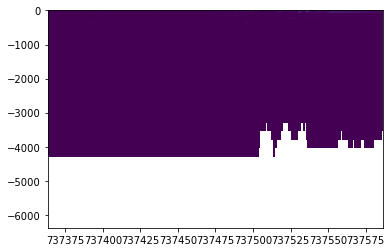

In [11]:
class Kz_processing:
    def __init__(self, mesh, data):
        self.process_profile_data(mesh,data)
    def process_profile_data(self, mesh, data):
        
        # keep data that are in the simulation time interval
        ind1, ind2 = np.where(data.dates>=np.min(mesh.dates))[0], np.where(data.dates<=np.max(mesh.dates))[0]
        indices = list(set(ind1) & set(ind2))
        self.dates, self.z, K, self.nlevels = data.dates[indices], data.z, data.Kz[:,indices], mesh.nlevels
        
        # perform mask on array
        Kz = np.zeros(K.shape)*np.nan
        for i in range(len(self.dates)):
            # initialization step
            k, nl = K[:,i], int(mesh.nlevels[i])
            # fill with value according to number of levels and bathymetry
            Kz[0:nl,i] = k[0:nl]
        
        # store data
        self.Kz=Kz
        
        fig,ax = plt.subplots(1)
        ax.pcolor(self.dates, self.z, self.Kz)
            
#
# process vertical Kz profiles so they are collocated with the mesh nodes
#
Kz_processed = Kz_processing(mesh,Kz)

In [15]:
class Kz_Output:
    def __init__(self, filename, data):
        self.write_ocn_forcing(filename, data)
    
    def write_ocn_forcing(self,filename, data):
        #------------------------------------------------------------------------
        # write ITP salinity and temperature profile to netcdf
        #------------------------------------------------------------------------	
    
        # open file
        ncid = Dataset(filename, "w", format="NETCDF4")

        # define dimension
        nt, nlvl = len(data.dates), len(data.z)
    
        ncid.createDimension('time', nt)
        ncid.createDimension('levels', nlvl)
        dimt, dimlvl, dim = ('time'), ('levels'), ('levels','time') 
        
        # create variable
        dat = ncid.createVariable('dates', "f8", dimt)
        Z = ncid.createVariable('z', "f8",dimlvl)
        kz = ncid.createVariable('Kz', "f8",dim)
        nlvl = ncid.createVariable('nlevels', "f8", dimt)

        
        # define units
        dat.units, dat.description = 'days', 'days since '+ str(datetime.fromordinal(int(data.dates[0])))
        Z.units, kz.units = 'm', 'm2/s2'
        Z.long_name, kz.long_name = 'z', 'vertical diffusivity'
        nlvl.long_name='nb of levels at nodes'
        #fill variables
        ncid['dates'][:], ncid['z'][:], ncid['Kz'][:], ncid['nlevels'][:]  = data.dates, data.z, data.Kz, data.nlevels
   
        # close file
        ncid.close()
#
# write to data to netcdf
path_data = '/home/fbirrien/NuArctic/nuarctic/Data_Processing/processed/'
filename = path_data + 'MOSAiC_MSS_daily_Kz.nc'
Kz_Output(filename, Kz_processed)
